In [1]:
import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"
import random
from glob import glob
import os, shutil
from tqdm import tqdm
tqdm.pandas()
import time
import copy
import joblib
import gc
from IPython import display as ipd
from joblib import Parallel, delayed

# visualization
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import tensorflow as tf

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = np.asarray(mask_rle.split(), dtype=int)
    starts = s[0::2] - 1
    lengths = s[1::2]
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction


# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def get_metadata(row):
    data = row['id'].split('_')
    case = int(data[0].replace('case',''))
    day = int(data[1].replace('day',''))
    slice_ = int(data[-1])
    row['case'] = case
    row['day'] = day
    row['slice'] = slice_
    return row

def path2info(row):
    path = row['image_path']
    data = path.split('/')
    slice_ = int(data[-1].split('_')[1])
    case = int(data[-3].split('_')[0].replace('case',''))
    day = int(data[-3].split('_')[1].replace('day',''))
    width = int(data[-1].split('_')[2])
    height = int(data[-1].split('_')[3])
    row['height'] = height
    row['width'] = width
    row['case'] = case
    row['day'] = day
    row['slice'] = slice_
    return row

def id2mask(id_):
    idf = df[df['id']==id_]
    wh = idf[['height','width']].iloc[0]
    shape = (wh.height, wh.width, 3)
    mask = np.zeros(shape, dtype=np.uint8)
    for i, class_ in enumerate(['large_bowel', 'small_bowel', 'stomach']):
        cdf = idf[idf['class']==class_]
        rle = cdf.segmentation.squeeze()
        if len(cdf) and not pd.isna(rle):
            mask[..., i] = rle_decode(rle, shape[:2])
    return mask

def rgb2gray(mask):
    pad_mask = np.pad(mask, pad_width=[(0,0),(0,0),(1,0)])
    gray_mask = pad_mask.argmax(-1)
    return gray_mask

def gray2rgb(mask):
    rgb_mask = tf.keras.utils.to_categorical(mask, num_classes=4)
    return rgb_mask[..., 1:].astype(mask.dtype)

def load_img(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = img.astype('float32') # original is uint16
    img = (img - img.min())/(img.max() - img.min())*255.0 # scale image to [0, 255]
    img = img.astype('uint8')
    return img

def show_img(img, mask=None):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
#     plt.figure(figsize=(10,10))
    plt.imshow(img, cmap='bone')
    
    if mask is not None:
        # plt.imshow(np.ma.masked_where(mask!=1, mask), alpha=0.5, cmap='autumn')
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = [ "Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
    plt.axis('on')

In [2]:
df = pd.read_csv('/home/yiw/gi/input/train.csv')
df = df.progress_apply(get_metadata, axis=1)
pd.set_option('display.max_rows', None)
df.head(200)
# 第一步添加 case day slice 这三列

100%|██████████| 115488/115488 [01:27<00:00, 1314.85it/s]


,id,class,segmentation,case,day,slice
0,case123_day20_slice_0001,large_bowel,NaN,123,20,1
1,case123_day20_slice_0001,small_bowel,NaN,123,20,1
2,case123_day20_slice_0001,stomach,NaN,123,20,1
3,case123_day20_slice_0002,large_bowel,NaN,123,20,2
4,case123_day20_slice_0002,small_bowel,NaN,123,20,2
5,case123_day20_slice_0002,stomach,NaN,123,20,2
6,case123_day20_slice_0003,large_bowel,NaN,123,20,3
7,case123_day20_slice_0003,small_bowel,NaN,123,20,3
8,case123_day20_slice_0003,stomach,NaN,123,20,3
9,case123_day20_slice_0004,large_bowel,NaN,123,20,4


In [3]:
# 新建一个df 准备image_path
paths = glob('/home/yiw/gi/input/train/*/*/*/*')
path_df = pd.DataFrame(paths, columns=['image_path'])
path_df = path_df.progress_apply(path2info, axis=1)
df = df.merge(path_df, on=['case','day','slice'])
df.head()
# 添加 image_path, height, width 这三列

100%|██████████| 38496/38496 [00:46<00:00, 834.52it/s]


,id,class,segmentation,case,day,slice,image_path,height,width
0,case123_day20_slice_0001,large_bowel,NaN,123,20,1,/home/yiw/gi/input/train/case123/case123_day20...,266,266
1,case123_day20_slice_0001,small_bowel,NaN,123,20,1,/home/yiw/gi/input/train/case123/case123_day20...,266,266
2,case123_day20_slice_0001,stomach,NaN,123,20,1,/home/yiw/gi/input/train/case123/case123_day20...,266,266
3,case123_day20_slice_0002,large_bowel,NaN,123,20,2,/home/yiw/gi/input/train/case123/case123_day20...,266,266
4,case123_day20_slice_0002,small_bowel,NaN,123,20,2,/home/yiw/gi/input/train/case123/case123_day20...,266,266


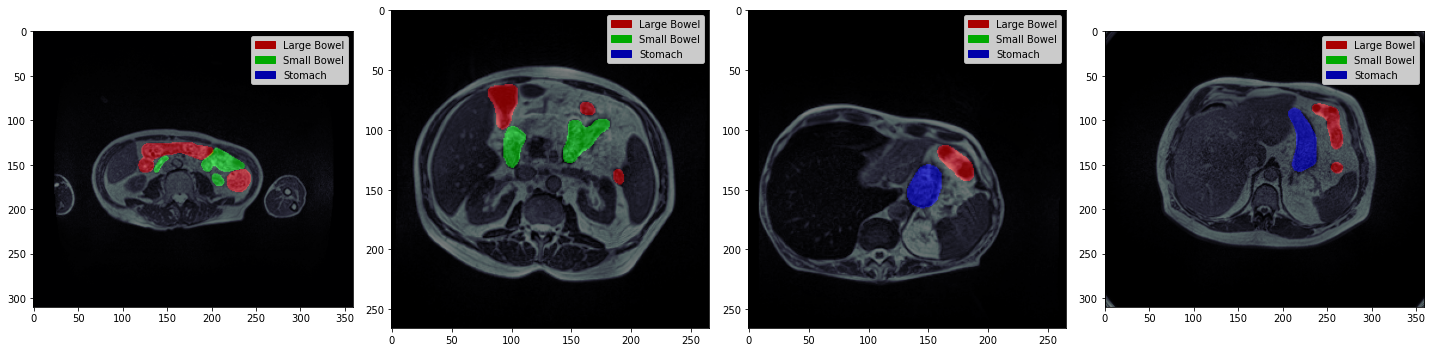

In [4]:
row=1; col=4
plt.figure(figsize=(5*col,5*row))
for i, id_ in enumerate(df[~df.segmentation.isna()].sample(frac=1.0)['id'].unique()[:row*col]):
    img = load_img(df[df['id']==id_].image_path.iloc[0])
    mask = id2mask(id_)*255
    plt.subplot(row, col, i+1)
    i+=1
    show_img(img, mask=mask)
    plt.tight_layout()

In [5]:
def save_mask(id_):
    idf = df[df['id']==id_]
    mask = id2mask(id_)*255
    image_path = idf.image_path.iloc[0]
    mask_path = image_path.replace('/home/yiw/gi/input/','/tmp/png/')
    mask_folder = mask_path.rsplit('/',1)[0]
    os.makedirs(mask_folder, exist_ok=True)
    cv2.imwrite(mask_path, mask, [cv2.IMWRITE_PNG_COMPRESSION, 1])
    mask_path2 = image_path.replace('/home/yiw/gi/input/','/tmp/np/').replace('.png','.npy')
    mask_folder2 = mask_path2.rsplit('/',1)[0]
    os.makedirs(mask_folder2, exist_ok=True)
    np.save(mask_path2, mask)
    return mask_path

ids = df['id'].unique()
_ = Parallel(n_jobs=-1, backend='threading')(delayed(save_mask)(id_)\
                                             for id_ in tqdm(ids, total=len(ids)))

100%|██████████| 38496/38496 [11:47<00:00, 54.41it/s]


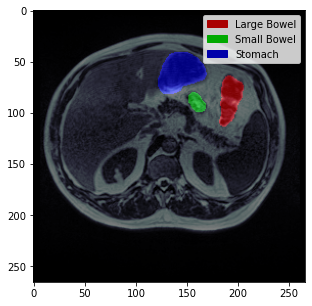

In [6]:
i = 250
img = load_img(df.image_path.iloc[i])
mask_path = df['image_path'].iloc[i].replace('/home/yiw/gi/input/','/tmp/png/')
mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
plt.figure(figsize=(5,5))
show_img(img, mask=mask)

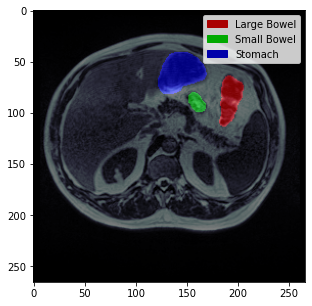

In [7]:
i = 250
img = load_img(df.image_path.iloc[i])
mask_path = df['image_path'].iloc[i].replace('/home/yiw/gi/input/','/tmp/np/').replace('.png','.npy')
mask = np.load(mask_path)
plt.figure(figsize=(5,5))
show_img(img, mask=mask)

In [3]:
# import pandas as pd
# df = pd.read_csv("train_step0.csv")
df['mask_path'] = df.image_path.str.replace('/home/yiw/gi/input/train/','/home/yiw/gi/input/png/train/')
df.to_csv('train_step0.csv', index=False)
df.head(199)
# 将 /tmp/png 拷贝到 /home/yiw/gi/input/ 下
# 将 /tmp/np  拷贝到 /home/yiw/gi/input/ 下

,id,class,segmentation,case,day,slice,image_path,height,width,mask_path
0,case123_day20_slice_0001,large_bowel,NaN,123,20,1,/home/yiw/gi/input/train/case123/case123_day20...,266,266,/home/yiw/gi/input/png/train/case123/case123_d...
1,case123_day20_slice_0001,small_bowel,NaN,123,20,1,/home/yiw/gi/input/train/case123/case123_day20...,266,266,/home/yiw/gi/input/png/train/case123/case123_d...
2,case123_day20_slice_0001,stomach,NaN,123,20,1,/home/yiw/gi/input/train/case123/case123_day20...,266,266,/home/yiw/gi/input/png/train/case123/case123_d...
3,case123_day20_slice_0002,large_bowel,NaN,123,20,2,/home/yiw/gi/input/train/case123/case123_day20...,266,266,/home/yiw/gi/input/png/train/case123/case123_d...
4,case123_day20_slice_0002,small_bowel,NaN,123,20,2,/home/yiw/gi/input/train/case123/case123_day20...,266,266,/home/yiw/gi/input/png/train/case123/case123_d...
...,...,...,...,...,...,...,...,...,...,...
194,case123_day20_slice_0065,stomach,28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...,123,20,65,/home/yiw/gi/input/train/case123/case123_day20...,266,266,/home/yiw/gi/input/png/train/case123/case123_d...
195,case123_day20_slice_0066,large_bowel,NaN,123,20,66,/home/yiw/gi/input/train/case123/case123_day20...,266,266,/home/yiw/gi/input/png/train/case123/case123_d...
196,case123_day20_slice_0066,small_bowel,NaN,123,20,66,/home/yiw/gi/input/train/case123/case123_day20...,266,266,/home/yiw/gi/input/png/train/case123/case123_d...
197,case123_day20_slice_0066,stomach,27561 8 27825 11 28090 13 28355 14 28620 15 28...,123,20,66,/home/yiw/gi/input/train/case123/case123_day20...,266,266,/home/yiw/gi/input/png/train/case123/case123_d...
